In [24]:
import os
import requests
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm
from scipy.io import loadmat
from sklearn.model_selection import train_test_split

# Set seed for reproducible randomness
seed = 1
np.random.seed(seed)
rng = np.random.RandomState(seed)

# Pen-Tip Trajectories (Example)

This example notebook aims to showcase some of the preprocessing methods and classification algorithms offered by Sequentia on the [Character Trajectories Data Set](https://archive.ics.uci.edu/ml/datasets/Character+Trajectories). This dataset consists of pen-tip trajectories generated by writing English letters on a [WACOM tablet](https://www.wacom.com/en-us). 

The **$x$-velocity**, **$y$-velocity** and **pen-tip force** were recorded.

Some more specific details about the dataset:

- The data consists of 2858 character samples
- The data has been numerically differentiated and Gaussian smoothed
- Only characters with a single 'PEN-DOWN' segment were considered (these characters are shown later)
- Characters have been shifted so that their velocity profiles best match the mean of the set

Each character sample is a 3-dimensional pen tip velocity (and force) trajectory. This is contained in matrix format, with 3 rows and $T$ columns where $T$ is the length of the character sample, which represents our observation sequence.

---

- [Dynamic Time Warping $k$-NN](#Dynamic-Time-Warping-%24k%24-NN)
- [Hidden Markov Models](#Hidden-Markov-Models)

First, we will download the dataset and extract the samples and labels, then convert them so that they are in a format compatible with Sequentia (see the <a href="https://nbviewer.jupyter.org/github/eonu/sequentia/blob/master/notebooks/1%20-%20Input%20Format%20%28Tutorial%29.ipynb"><em>Input Format</em></a> notebook for more information): 

In [25]:
data = None
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/character-trajectories/mixoutALL_shifted.mat'

try:
    path = os.path.join(os.getcwd(), 'temp.mat')
    print('Downloading dataset from {} ...'.format(url))
    response = requests.get(url)
except:
    raise
else:
    with open(path, 'wb') as file:
        print('Temporarily writing data to file ...')
        file.write(response.content)
        print('Loading data into numpy.ndarray ...')
        data = loadmat(path)
        print('Done!')
finally:
    os.remove(path)

Temporarily writing data to file ...
Loading data into numpy.ndarray ...
Done!


In [26]:
# Load the trajectories
# NOTE: Transpose from 3xT to Tx3
X = [x.T for x in data['mixout'][0]]
print('Number of trajectories: {}'.format(len(X)))

Number of trajectories: 2858


Only lowercase characters with a single pen-down segment were considered in this dataset. In total, there were 20 of these characters as shown below:

In [27]:
# Retrieve the set of unique labels and report the number of labels
labels = [label[0] for label in data['consts'][0][0][3][0]]
n_labels = len(labels)
print('Labels: {}'.format(str(labels)))
print('Number of labels: {}'.format(n_labels))

Labels: ['a', 'b', 'c', 'd', 'e', 'g', 'h', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 'u', 'v', 'w', 'y', 'z']
Number of labels: 20


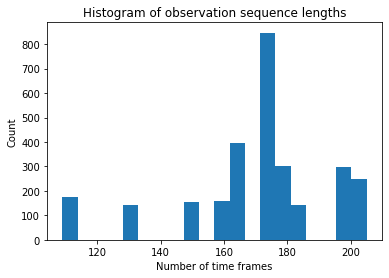

In [28]:
# View distribution of observation sequence lengths
plt.title('Histogram of observation sequence lengths')
plt.xlabel('Number of time frames')
plt.ylabel('Count')
plt.hist([len(x) for x in X], bins=n_labels)
plt.show()

Observation sequences in this dataset are padded so that all sequences in one class have the same duration. This can be undone by trimming zeros.

Additionally, the sample rate of each trajectory recording was 200hz–meaning that in every second, 200 pen-tip trajectories were recorded!

Although keeping all of these frames/data-points might result in a more accurate classifier, it also significantly increases the time required for training or prediction. This is especially the case for $k$-NN, since it is a non-parametric classifier that requires going through each training example during prediction time.

---

To fix the problems of zero-padding and the excessive frame count, we can use the `Preprocess` class to perform zero-trimming and downsampling transformations:

In [29]:
from sequentia.preprocessing import *

pre = Preprocess([
    # Trim zero-observations
    TrimZeros(), 
    # Downsample with averaging and a downsample factor of n=15
    # Downsample(factor=5, method='mean')
])

# Display a summary of the preprocessing transformations
pre.summary()

   Preprocessing summary:  
1. TrimZeros
   Remove zero-observations


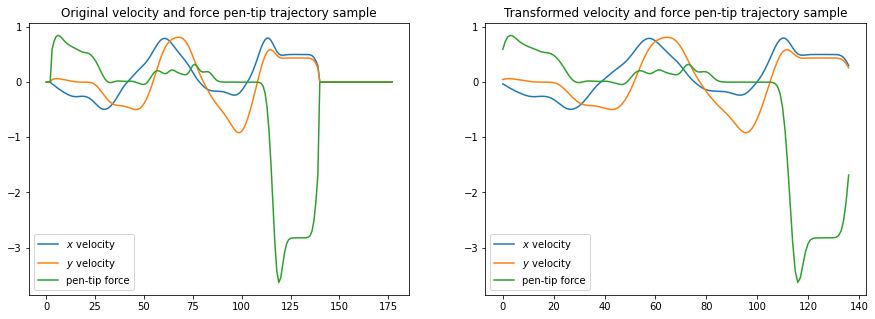

In [30]:
# Pick an example trajectory for visualization
x = X[0]

# Downsample the example trajectory, using a downsample factor of n=10
x_pre = pre.transform(x)

# Create the plot to visualize the downsampling
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(x)
ax1.set_title('Original velocity and force pen-tip trajectory sample')
ax1.legend(labels=['$x$ velocity', '$y$ velocity', 'pen-tip force'])
ax2.plot(x_pre)
ax2.set_title('Transformed velocity and force pen-tip trajectory sample')
ax2.legend(labels=['$x$ velocity', '$y$ velocity', 'pen-tip force'])
plt.show()

To visualize how zero-trimming affects the dataset, we will plot a histogram of the zero-trimmed observation sequence lengths. 

We can then apply this transformation to the entire dataset. 

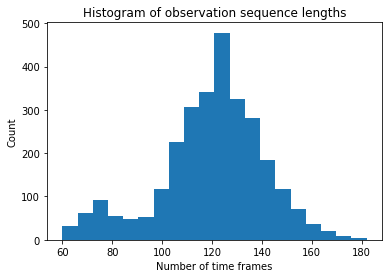

In [31]:
# View distribution of trimmed observation sequence lengths
plt.title('Histogram of observation sequence lengths')
plt.xlabel('Number of time frames')
plt.ylabel('Count')
plt.hist([len(x) for x in TrimZeros()(X)], bins=n_labels)
plt.show()

# Transform the entire dataset
X = pre.transform(X)

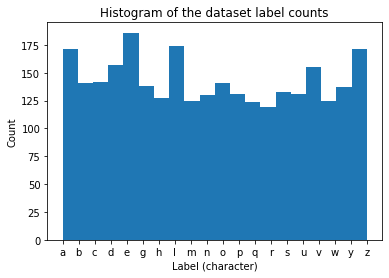

In [32]:
# Extract the labels
y = [labels[idx - 1] for idx in data['consts'][0][0][4][0]]

# Plot a histogram of the labels for each class
plt.title('Histogram of the dataset label counts')
plt.xlabel('Label (character)')
plt.ylabel('Count')
plt.hist(y, bins=n_labels)
plt.show()

In [33]:
# Shuffle and split the dataset into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rng, shuffle=True)
print('Training set size: {}'.format(len(X_train)))
print('Test set size: {}'.format(len(X_test)))

Training set size: 2286
Test set size: 572


In [34]:
# Create a function for displaying results (accuracy and confusion matrix)
def show_results(acc, cm, dataset):
    df = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df, annot=True)
    plt.title('Confusion matrix for {} set predictions'.format(dataset), fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    # Fix for matplotlib bug that cuts off top/bottom of seaborn visualizations
    b, t = plt.ylim()
    plt.ylim(b + 0.5, t - 0.5)
    plt.show()
    print('Accuracy: {:.2f}%'.format(acc * 100))

## Dynamic Time Warping $k$-NN

The $k$-Nearest Neighbor ($k$-NN) classifier is a conceptually simple machine learning algorithm that is also easy to implement. As a result, it is often used as a baseline, despite often being able to perform much better than more complex algorithms.

However, applying $k$-NN to isolated observation sequences is not so straightforward since different observation sequences may have different durations, making it difficult to come up with a distance measure that can be used to compare the two sequences. 

One such appropriate distance measure is [Dynamic Time Warping](https://en.wikipedia.org/wiki/Dynamic_time_warping).
When combined with $k$-NN, this makes a very powerful sequence classifier.

---

Importing, creating and fitting the classifier:

In [38]:
from sequentia.classifiers import KNNClassifier

# Create and fit a kNN classifier using the single nearest neighbor and fast C compiled DTW functions
clf = KNNClassifier(k=1, classes=labels, window=1, use_c=True)
clf.fit(X_train, y_train)

TypeError: Expected Sakoe-Chiba band width (fraction) to be a float

In [36]:
clf = KNNClassifier(k=1, classes=labels, use_c=True)
clf.fit(X_train, y_train)
for window in np.arange(11)/10:
    clf._window = window
    acc, _ = clf.evaluate(X_test, y_test, n_jobs=-1)
    print('window={}, acc={:.2f}%'.format(window, acc*100))

window=0.0, acc=98.08%
window=0.1, acc=97.55%
window=0.2, acc=98.25%
window=0.3, acc=98.08%
window=0.4, acc=98.08%
window=0.5, acc=98.08%
window=0.6, acc=98.08%
window=0.7, acc=98.08%
window=0.8, acc=98.08%
window=0.9, acc=98.08%
window=1.0, acc=98.08%


To predict single or multiple examples, we can use the `predict` function:

In [13]:
# Predict the first test example
clf.predict(X_test[0])

Calculating distances:   0%|          | 0/2286 [00:00<?, ?it/s]

'w'

In [14]:
%%time
# Predict the first 50 test examples
predictions = clf.predict(X_test[:50])
print(*predictions, sep=' ', end='\n\n')

Classifying examples (process 1):   0%|          | 0/50 [00:00<?, ?it/s]

w c d e a e b h s v c y w e v v w v v b o e l c d c p n h p y p m h d u y d b h m m a g o g c n l y

CPU times: user 6.71 s, sys: 301 ms, total: 7.01 s
Wall time: 7.78 s


This can be sped up a bit by using multiple jobs, as specified by `n_jobs`. By default this is set to 1. A setting of -1 will use all available cores:

In [15]:
%%time
# NOTE: Progress bars for predict() and evaluate() are only displayed in the console if multiple jobs are used
predictions = clf.predict(X_test[:50], n_jobs=-1)
print(*predictions, sep=' ', end='\n\n')

w c d e a e b h s v c y w e v v w v v b o e l c d c p n h p y p m h d u y d b h m m a g o g c n l y

CPU times: user 739 ms, sys: 95.5 ms, total: 834 ms
Wall time: 5.54 s


To calculate the model's accuracy and confusion matrix on some data, we can use the `evaluate` function:

In [16]:
%%time
acc, cm = clf.evaluate(X_test, y_test, n_jobs=-1)

CPU times: user 584 ms, sys: 17.6 ms, total: 601 ms
Wall time: 38.3 s


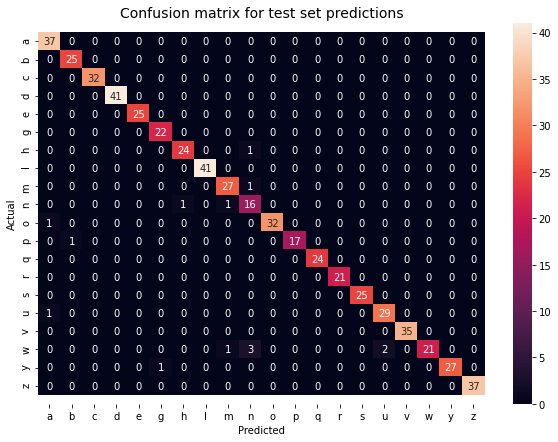

Accuracy: 97.55%


In [17]:
show_results(acc, cm, dataset='test')

As you can see, Dynamic Time Warping $k$-NN classification often works with very good performance, but can suffer due to the fact that $k$-NN must look through every training example when we make a single prediction.

While the fast C compiled functions in the [`dtaidistance`](https://github.com/wannesm/dtaidistance) package (along with the multiprocessing capabilities of Sequentia's `KNNClassifier`) help to speed up classification **a lot**, the practical use of $k$-NN becomes more limited as the dataset grows larger. 

In this case, since our dataset is relatively small, classifying all test examples was completed in $\approx40s$, which is even faster than the HMM classifier that we show below. 

## Hidden Markov Models

A group of HMMs can be a good classifier for isolated sequences. The main idea behind using HMMs for classification is as follows:

1. Create $N$ HMMs $\lambda_1,\lambda_2,\ldots,\lambda_C$, each representing a different class (character in this case).
2. Fit each of these HMMs only using the training examples labeled with the class that the HMM represents. _The Baum-Welch algorithm is used for training here_.
3. For a new observation sequence $O$, calculate the likelihood of each HMM generating $O$–that is, calculate $\mathbb{P}(O|\lambda_c) \quad \forall c\in\{1, 2, \ldots, C\}$. _This is done using the Forward algorithm_.
4. Then $O$ is then classified as the class corresponding to the HMM that was most likely to generate $O$, giving a classification rule of: 

$$c^*=\mathop{\arg\max}_{c\in\{1,2,\ldots,C\}}\mathbb{P}(O|\lambda_c)$$

**Note**: In order to account for some classes naturally occurring more frequently than others, we can instead introduce a prior by using the Maximum A Posterior (MAP) classification rule:

$$c^*=\mathop{\arg\max}_{c\in\{1,2,\ldots,C\}}\mathbb{P}(O|\lambda_c)\mathbb{P}(\lambda_c)$$

---

Creating the individual `GMMHMM` objects and fitting each one on the training examples corresponding to the label (character) that it represents:

**Note**: Here we naively set the number of states for all HMMs to 10. In reality, you will probably want to have different numbers of states for HMMs that represent more complex or more simple characters.

In [18]:
from sequentia.classifiers import GMMHMM, HMMClassifier

hmms = []
for label in tqdm(labels, desc='Training HMMs'):
    hmm = GMMHMM(label=label, n_states=10, n_components=5, topology='linear', random_state=rng)
    hmm.set_random_initial()
    hmm.set_random_transitions()
    hmm.fit([X_train[i] for i, y_i in enumerate(y_train) if y_i == label])
    hmms.append(hmm)

Training HMMs:   0%|          | 0/20 [00:00<?, ?it/s]

A `HMMClassifier` object collects each of the individual `GMMHMM` objects in order to create the classifier:

In [19]:
clf = HMMClassifier()
clf.fit(hmms)

In [20]:
%%time
acc, cm = clf.evaluate(X_test, y_test)

CPU times: user 3min 23s, sys: 16.4 s, total: 3min 40s
Wall time: 2min 12s


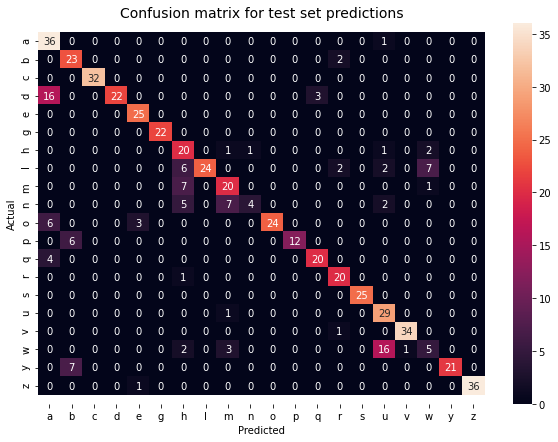

Accuracy: 79.37%


In [21]:
show_results(acc, cm, dataset='test')